In [1]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
warnings.filterwarnings('ignore')

In [2]:
def my_accuracy(y_true, y_pred):
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return accuracy_score(y_true, y_pred)

def gs_regressor_params(parameters ={}, check_parameter={}, metric="accuracy", reg=None, n_splits=1, test_size=0.20):
    metric = make_scorer(my_accuracy)
    cv = TimeSeriesSplit(n_splits=n_splits)
    gs_reg = GridSearchCV(reg, parameters, cv=cv, scoring=metric, return_train_score=True, verbose=False)
    gs_reg.fit(X_train,y_train)
    plot_gs_results(gs_model=gs_reg, params=parameters, check_params = check_parameter, model_name=str(reg))

In [3]:
def loss_function(res, pred):
    return (pred[0] - res) ** 2 + (pred[1] - abs(res - 1)) ** 2

def aggregate(res, pred_df, loss_func = loss_function, weights = None, m = 2):
    val = df.values.transpose()
    pred = np.array(list(map(lambda x : np.array(list(map(list, x))), val)))
    T = len(res)
    K = len(pred)
    res_df = pd.DataFrame()
    names = df.columns
    for i in range(K):
        res_df[names[i] + '_mean'] = np.zeros(T)
        res_df[names[i] + '_mean_100'] = np.zeros(T)
        res_df[names[i] + '_accumulated'] = np.zeros(T)
        res_df[names[i] + '_weight'] = np.zeros(T)
    res_df['composition_mean'] = np.zeros(T)
    res_df['composition_mean_100'] = np.zeros(T)
    res_df['composition_accumulated'] = np.zeros(T)
    if not weights:
        weights = np.full(K, 1/K)
    agg_pred = np.zeros(2 * T).reshape(T, 2)
    for t in range(1, T):
        gamma = pred[:,t]
        def G(omega):
            return -np.log(np.inner(weights, np.exp(-loss_func(omega, np.transpose(gamma)))))
        ''' = (G(0) + G(1)) / 2 + 1  #Срезка, а не модуль
        s2 = (G(0) + G(1)) / 2 - 1
        if s1 > G(0) and s1 > G(1):
            s = s1
        if s2 < G(0) and s2 < G(1):
            s = s2'''
        delta = abs(G(1) - G(0))
        if (delta >= m):
            s = min(G(1), G(0)) + m
        else:
            s = (m + G(0) + G(1)) / 2
        #print(max(s - G(0), 0) + max(s - G(1), 0), G(0), G(1), delta, s)
        weights = (weights * np.exp(-loss_func(res[t], np.transpose(gamma))))
        weights /= np.sum(weights)
        agg_pred[t] = np.array([abs(s - G(1)) / 2, abs(s - G(0)) / 2])
        agg_pred[t] = agg_pred[t]
        for i in range(K):
            res_df[names[i]+'_accumulated'][t] = res_df[names[i]+'_accumulated'][t - 1] + loss_func(res[t], gamma[i])
            res_df[names[i]+'_mean'][t] = res_df[names[i]+'_accumulated'][t] / t
            res_df[names[i] + '_weight'][t] = weights[i]
            if t > 100:
                res_df[names[i]+'_mean_100'][t] = (res_df[names[i]+'_accumulated'][t] - res_df[names[i]+'_accumulated'][t - 100]) / 100
            else:
                res_df[names[i]+'_mean_100'][t] = res_df[names[i]+'_mean'][t]
        res_df['composition_accumulated'][t] = res_df['composition_accumulated'][t - 1] + loss_func(res[t], agg_pred[t])
        res_df['composition_mean'][t] = res_df['composition_accumulated'][t] / t
        if t > 100:
            res_df['composition_mean_100'][t] = (res_df['composition_accumulated'][t] - res_df['composition_accumulated'][t - 100]) / 100
        else:
            res_df['composition_mean_100'][t] = res_df['composition_mean'][t]
    res_df['composition_k1'] = agg_pred.transpose()[0]
    res_df['composition_k2'] = agg_pred.transpose()[1]
    return res_df

In [4]:
data = pd.read_pickle('final_data.pkl')
#data = pd.read_pickle('books&user.pkl')
#data = pd.read_csv('egor_noob.csv', encoding='utf-8')
print(data.shape)
data.head(1)

(34588, 132)


,,,Surface,hour,round,p1_win,p1_age,p2_age,k1,k2,p1_height,p2_height,...,p2_filter_lag_1_receiver_points_won_match__mean_28,p2_filter_lag_1_receiver_points_won_match__median_28,p1_lag_1_match_duration_mnt_mean_28,p1_lag_1_match_duration_mnt_median_28,p1_filter_lag_1_match_duration_mnt_mean_28,p1_filter_lag_1_match_duration_mnt_median_28,p2_lag_1_match_duration_mnt_mean_28,p2_lag_1_match_duration_mnt_median_28,p2_filter_lag_1_match_duration_mnt_mean_28,p2_filter_lag_1_match_duration_mnt_median_28
date,p1,p2,,,,,,,,,,,,,,,,,,,,,
2015-06-01,Gasquet R.,Djokovic N.,0.0,18,1.0,0,28.046575,28.972603,19.0,1.0,1.88,1.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
y = data['p1_win'].astype(int)
X = data.drop(['p1_win'], axis=1)
date_idx = X.index.get_level_values('date')

In [6]:
X_test = X[(date_idx >= '2019-01-01') & (date_idx < '2020-01-01')]
y_test = y[(date_idx >= '2019-01-01') & (date_idx < '2020-01-01')]
X_train = X[(date_idx < '2019-01-01')]
y_train = y[(date_idx < '2019-01-01')]

In [25]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.4],
    'colsample_bytree': [0.8],
    'n_estimators': [260],
    'eval_metric' :["logloss"]
}
metric = make_scorer(my_accuracy)
cv = TimeSeriesSplit(n_splits=10)
gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)



In [26]:
xgpred = np.zeros(180000 * 2).reshape(180000, 2)
days=30
date = datetime.datetime(2019, 1, 1)
start = 0
for i in range(12):
    start_time = time.time()
    wall = date.strftime("%Y-%m-%d")
    XX_test = X[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=days)).strftime("%Y-%m-%d"))]
    yy_test = y[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=days)).strftime("%Y-%m-%d"))]
    XX_train = X[(date_idx < wall)]
    yy_train = y[(date_idx < wall)]
    if XX_test.shape[0] != 0:
        metric = make_scorer(my_accuracy)
        cv = TimeSeriesSplit(n_splits=10)
        week_gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)
        week_model = week_gs_reg.fit(XX_train,yy_train)
        week_xgpred = np.array(list(map(lambda x: np.array([x[1], x[0]]), week_model.predict_proba(XX_test))))
        xgpred[start:start+XX_test.shape[0]] = week_xgpred
        start += XX_test.shape[0]
    print(date.strftime("%Y-%m-%d") , time.time() - start_time, 'seconds')
    date += datetime.timedelta(days=days)
xgpred = xgpred[:start]

2019-01-01 37.28724980354309 seconds
2019-01-31 39.743889808654785 seconds
2019-03-02 41.9724543094635 seconds
2019-04-01 42.53140306472778 seconds
2019-05-01 44.6145977973938 seconds
2019-05-31 46.54056406021118 seconds
2019-06-30 48.32520580291748 seconds
2019-07-30 50.31953525543213 seconds
2019-08-29 52.93947076797485 seconds
2019-09-28 53.882803201675415 seconds
2019-10-28 53.219682931900024 seconds
2019-11-27 55.80730700492859 seconds


In [27]:
xgpred_late = np.zeros(180000 * 2).reshape(180000, 2)
days=30
date = datetime.datetime(2019, 1, 1)
start = 0
for i in range(12):
    start_time = time.time()
    wall = date.strftime("%Y-%m-%d")
    XX_test = X[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=days)).strftime("%Y-%m-%d"))]
    yy_test = y[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=days)).strftime("%Y-%m-%d"))]
    XX_train = X[date_idx < (date + datetime.timedelta(days=-365)).strftime("%Y-%m-%d")]
    yy_train = y[date_idx < (date + datetime.timedelta(days=-365)).strftime("%Y-%m-%d")]
    if XX_test.shape[0] != 0:
        metric = make_scorer(my_accuracy)
        cv = TimeSeriesSplit(n_splits=10)
        week_gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)
        week_model_late = week_gs_reg.fit(XX_train,yy_train)
        week_xgpred_late = np.array(list(map(lambda x: np.array([x[1], x[0]]), week_model_late.predict_proba(XX_test))))
        xgpred_late[start:start+XX_test.shape[0]] = week_xgpred_late
        start += XX_test.shape[0]
    print(date.strftime("%Y-%m-%d") , time.time() - start_time, 'seconds')
    date += datetime.timedelta(days=days)
xgpred_late = xgpred_late[:start]

2019-01-01 24.750340223312378 seconds
2019-01-31 25.925858736038208 seconds
2019-03-02 28.003100872039795 seconds
2019-04-01 29.608712673187256 seconds
2019-05-01 30.472615480422974 seconds
2019-05-31 33.26168370246887 seconds
2019-06-30 33.709070920944214 seconds
2019-07-30 33.980408668518066 seconds
2019-08-29 40.60097551345825 seconds
2019-09-28 40.354032039642334 seconds
2019-10-28 41.65246891975403 seconds
2019-11-27 41.68277931213379 seconds


In [29]:
print(xgpred.shape)
print(xgpred_late.shape)

(6924, 2)
(6924, 2)


In [30]:
#xgpred_upgrade_30 = xgpred_upgrade_30[:xgpred_upgrade_7.shape[0]]
#xgpred_upgrade_14 = xgpred_upgrade_14[:xgpred_upgrade_7.shape[0]]
dff = data[(date_idx >= '2019-01-01') & (date_idx < '2020-01-01')]

res = np.array(dff['p1_win'])

k1 = 1 / np.array(dff['k1'])
k2 = 1 / np.array(dff['k2'])
cfs = np.array([k1, k2])
cfs[0] /= (k1 + k2)
cfs[1] /= (k1 + k2)
cfs = cfs.transpose()

pred = np.array([xgpred, xgpred_late])
pred_list = list(map(lambda x : list(map(list, x)), pred))
df = pd.DataFrame(pred_list).transpose()
df.columns=['xgpred', 'xgpred_late']

In [31]:
df

,xgpred,xgpred_late
0,"[0.21877729892730713, 0.7812227010726929]","[0.2210092395544052, 0.7789907455444336]"
1,"[0.5676435232162476, 0.43235647678375244]","[0.5554249882698059, 0.4445750117301941]"
2,"[0.5460285544395447, 0.4539714455604553]","[0.5447272062301636, 0.4552727937698364]"
3,"[0.37230831384658813, 0.6276916861534119]","[0.36914053559303284, 0.6308594942092896]"
4,"[0.5609614253044128, 0.43903857469558716]","[0.5469145178794861, 0.4530854821205139]"
...,...,...
6919,"[0.42599695920944214, 0.5740030407905579]","[0.43353378772735596, 0.566466212272644]"
6920,"[0.49915415048599243, 0.5008458495140076]","[0.5040528774261475, 0.49594712257385254]"
6921,"[0.5068115592002869, 0.49318844079971313]","[0.5097352862358093, 0.4902647137641907]"
6922,"[0.38827013969421387, 0.6117298603057861]","[0.3895567059516907, 0.6104432940483093]"


In [32]:
agg = aggregate(res, df)

In [33]:
agg

,xgpred_mean,xgpred_mean_100,xgpred_accumulated,xgpred_weight,xgpred_late_mean,xgpred_late_mean_100,xgpred_late_accumulated,xgpred_late_weight,composition_mean,composition_mean_100,composition_accumulated,composition_k1,composition_k2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.644438,0.644438,0.644438,0.493139,0.616994,0.616994,0.616994,0.506861,0.630433,0.630433,0.630433,0.561452,0.438569
2,0.620366,0.620366,1.240733,0.492430,0.605225,0.605225,1.210449,0.507570,0.612642,0.612642,1.225285,0.545368,0.454632
3,0.676242,0.676242,2.028726,0.494423,0.668806,0.668806,2.006417,0.505577,0.672434,0.672434,2.017302,0.370710,0.629294
4,0.664520,0.664520,2.658082,0.486645,0.651162,0.651162,2.604648,0.513355,0.657639,0.657639,2.630557,0.553752,0.446272
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6919,0.414778,0.443117,2869.849368,0.878149,0.415064,0.444630,2871.824389,0.121851,0.414818,0.443292,2870.124273,0.426916,0.573081
6920,0.414791,0.447432,2870.351061,0.877101,0.415075,0.448930,2872.316316,0.122899,0.414830,0.447606,2870.624761,0.499756,0.500244
6921,0.414805,0.451895,2870.864777,0.877740,0.415090,0.453502,2872.835977,0.122260,0.414845,0.452084,2871.139202,0.507169,0.492831
6922,0.414853,0.458493,2871.613204,0.877402,0.415137,0.460104,2873.581259,0.122598,0.414893,0.458683,2871.887243,0.388428,0.611572


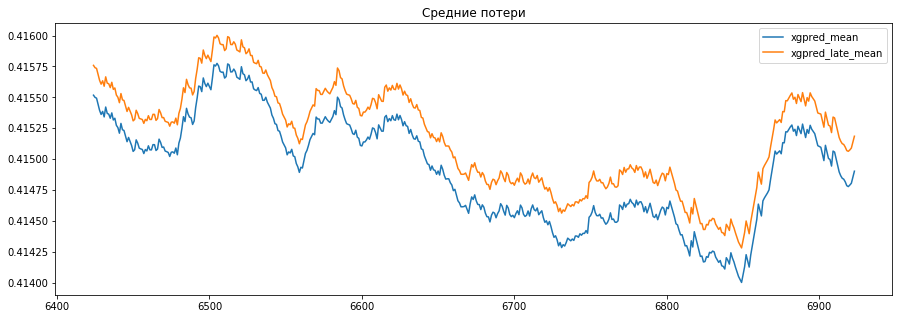

In [38]:
agg[['xgpred_mean', 'xgpred_late_mean']].tail(500).plot(figsize=(15, 5), title='Средние потери')

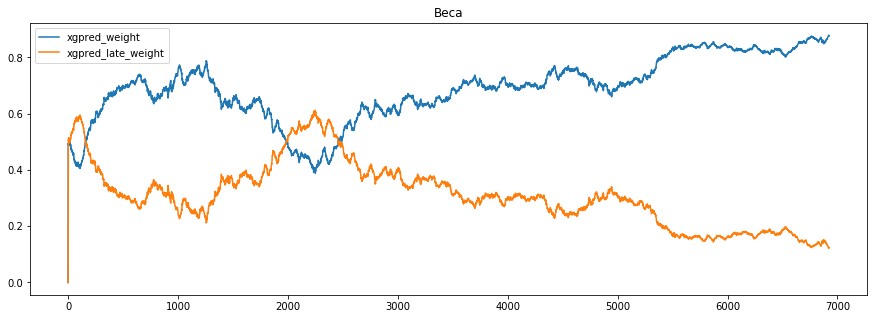

In [36]:
agg[['xgpred_weight', 'xgpred_late_weight']].plot(figsize=(15, 5), title='Веса')